# Example interlaboratory study

## Imports

Import the mumpce interface and the interface to interlab. 

In [1]:
import interlab as inl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Creating a Project

### Reading project metadata

`interlab` is agnostic to the way that your data is arranged. All that's required is that you have the experimental measurements divided logically into groups, where each group represents all the measurements of one sample. The exact way you do this is up to you; this example shows how to do create a {class}`.Project` using Pandas and an Excel workbook.

We've decided to remove some of the NMR data in the region of the water signal, so let's define the range that we'll actually use.

In [3]:
range_to_use = list(range(959)) + list(range(1058, 1860))

In [4]:
df_dict = pd.read_excel("syn_data.xlsx", sheet_name=None, index_col=0)

In [5]:
Spectrum_names = [key for key, df in df_dict.items()]
print(Spectrum_names)

['S1a', 'S1b', 'S1c', 'S1d', 'S1e', 'S1f', 'S2', 'S3', 'S4', 'S5', 'S6']


In [6]:
Labels_dict = {}

for key, df in df_dict.items():
    peakPPM_full = df.index.values[range_to_use]
    Labels = df.columns.values
    Labels_dict[key] = df.columns.values

print(Labels)
print(peakPPM_full)

['0115' '0122' '0258' '0333' '0711' '0714' '2861' '7042' '8865' '9541']
[9.9975 9.9925 9.9875 ... 0.2125 0.2075 0.2025]


In [7]:
jeffries = r"Symmetric Kullback-Liebler"
jensen = r"Jensen-Shannon"
hellinger = r"Hellinger"
mahalanobis = r"Mahalanobis"
nmr_distance_metrics = [
    dict(metric=mahalanobis, function="mahalanobis"),
    dict(metric=hellinger, function=inl.metrics.hellinger_hyp),
    dict(metric=jeffries, function=inl.metrics.jeffries),
    dict(metric=jensen, function=inl.metrics.jensen_hyp),
]

### Reading project data

Now that the metadata have all been read, we will actually read the data and create the data dictionaries. We extract the raw data for each experiment group directly from the dataframe, after we remove the water-signal data that we didn't want. This data goes into `rawdata_dict`. We use `fix_spectrum` to remove negative and zero values, then we sum-normalize the spectra. This goes into `data_dict`, which will actually be used for the interlab analysis.

In [8]:
rawdata_dict = {}
data_dict = {}

for key, df in df_dict.items():
    raw_values = df.values[range_to_use].T
    rawdata_dict[key] = raw_values

    normalized_values = inl.fix_spectrum(raw_values)
    data_dict[key] = (normalized_values.T / normalized_values.sum(axis=1)).T

### Creating the Project

Now we have enough data to create the {class}`.Project` object. When created, the Project will read the `rawdata_dict`, `data_dict`, and `Labels_dict`, associating each element of these dictionaries with an {class}`.ExperimentGroup` object.

In [9]:
synthetic_samples_project = inl.Project(
    x_data_list=peakPPM_full,
    Sample_names=Spectrum_names,
    Data_set_names=Labels_dict,
    distance_metrics=nmr_distance_metrics,
    data=data_dict,
    rawdata=rawdata_dict,
)

## Using Projects to run interlaboratory analysis

Now that we've created the project, we can begin to run the interlab analysis. 

### Interspectral distance matrices

#### Interspectral covariance matrix

Since we're using Mahalanobis distance as a metric, we need to calculate the inverse covariance matrix. As there are fewer observations than variables, we know the covariance matrix will be singular, so we need to use the singular value decomposition to calculate it.

In [10]:
synthetic_samples_project.process_mahalanobis()

In [11]:
synthetic_samples_project.set_distances()

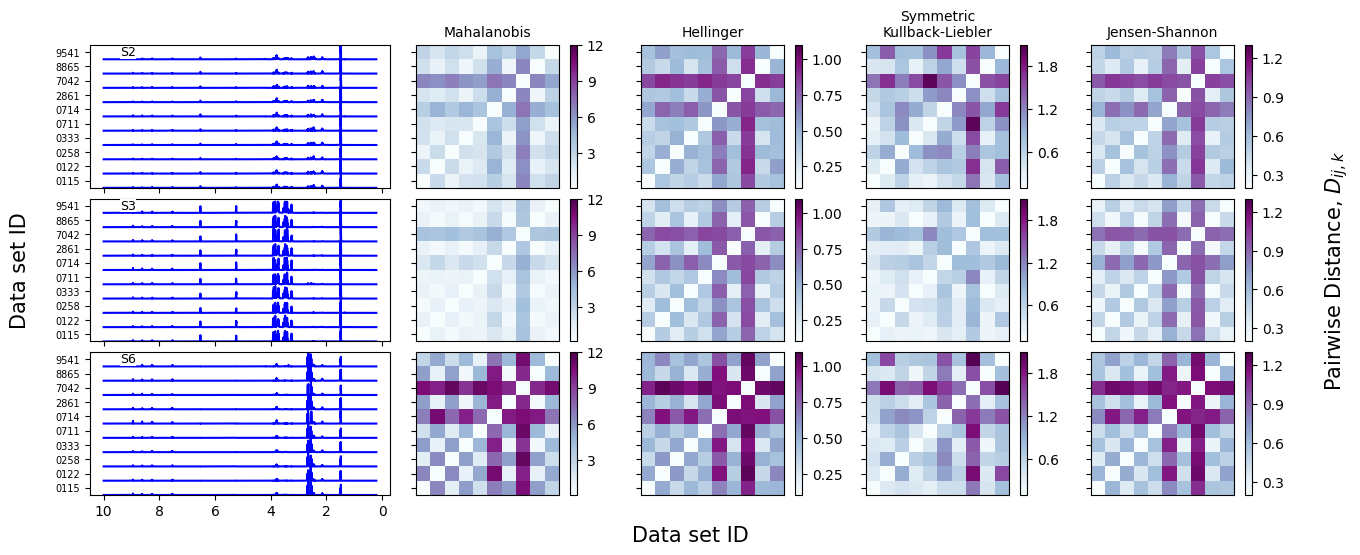

In [12]:
f = synthetic_samples_project.plot_distance_fig(
    linecolor="b", cmap="BuPu", plot_range=["S2", "S3", "S6"]
)

### Sample-level scores and outliers

Fit the scores to the distances, and then find the outliers.

In [13]:
synthetic_samples_project.fit_zscores()
synthetic_samples_project.find_outliers()

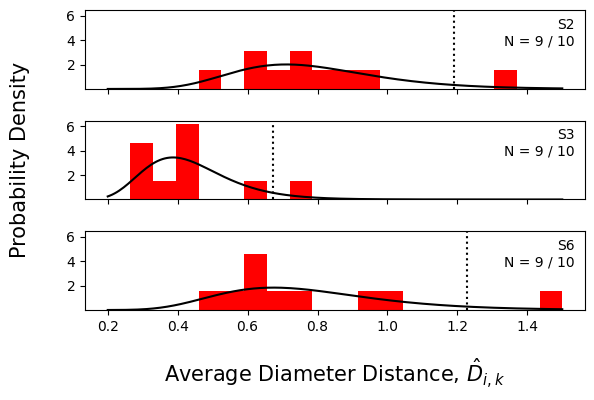

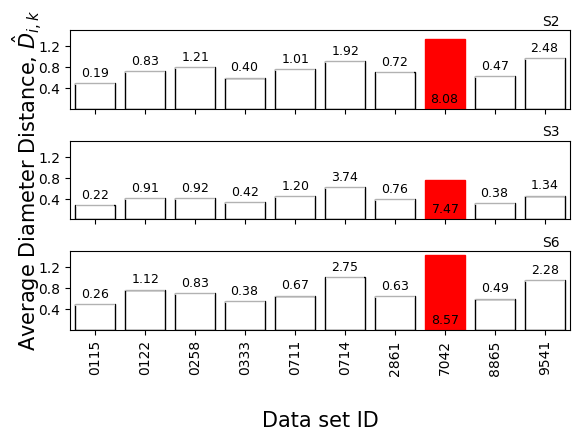

In [14]:
f = synthetic_samples_project.plot_histograms(
    jeffries, numcols=1, plot_range=["S2", "S3", "S6"]
)
f = synthetic_samples_project.plot_zscore_distances(
    jeffries, numcols=1, plot_range=["S2", "S3", "S6"]
)

### Interlaboratory statistical projection

The Z-scores can then be cast as an array, which we will then use to calculate the lab-level scores and determine outliers. Note how, in this case, we are not screening outlier spectra before we perform our analysis.

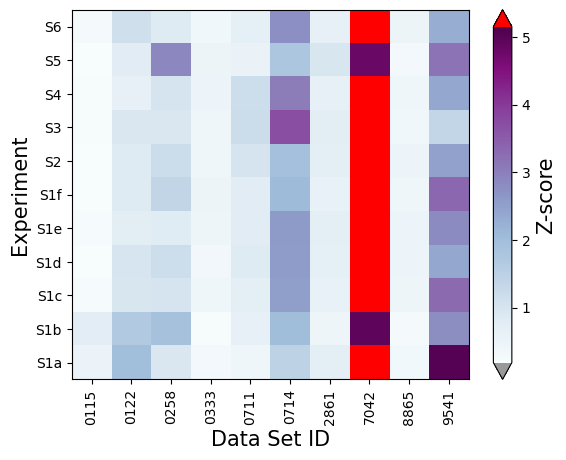

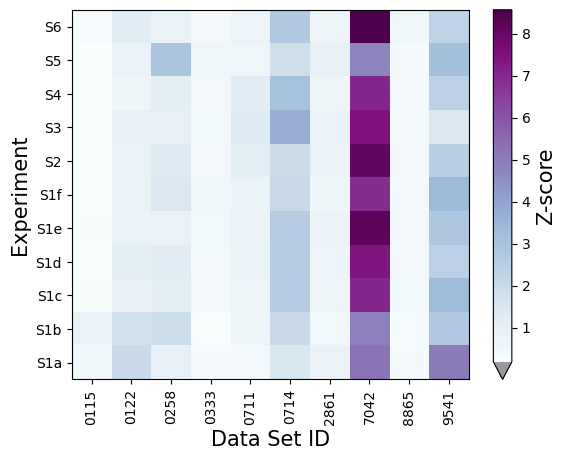

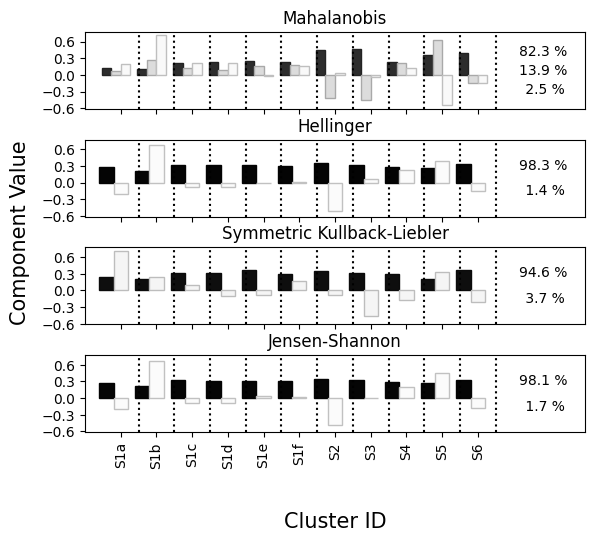

In [15]:
synthetic_samples_project.extract_matrices(screen_outliers=False)
synthetic_samples_project.plot_zscores_heatmap(metric=jeffries, cmap="BuPu")
synthetic_samples_project.plot_zscores_heatmap(
    screen_outliers=False, metric=jeffries, cmap="BuPu"
)
f = synthetic_samples_project.plot_zscore_loadings()

### Laboratory-level scoring and outliers

Find the outliers and plot the lab-level Z-scores as well as the statistical projection

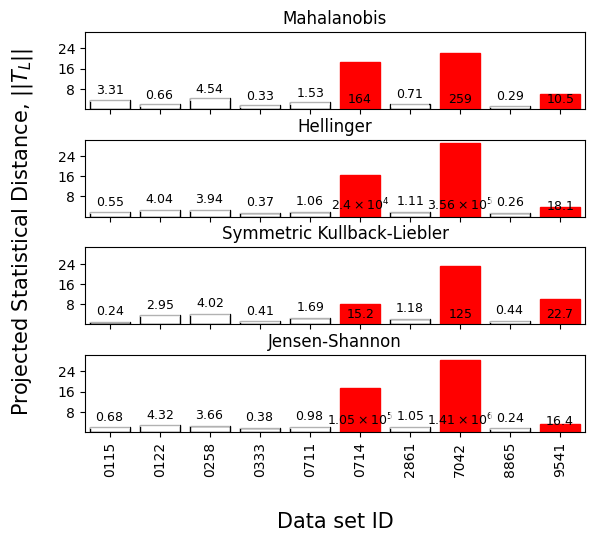

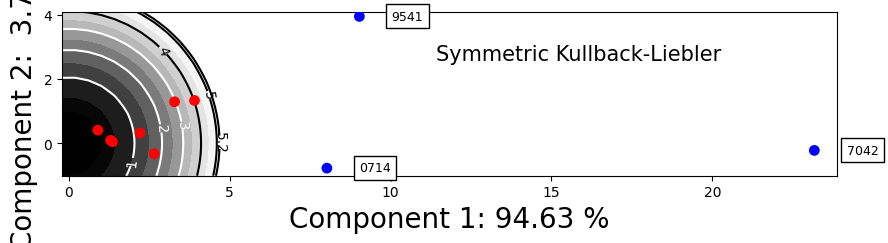

In [16]:
synthetic_samples_project.find_lab_outliers(recursive=True, support_fraction=0.6)
f = synthetic_samples_project.plot_projected_zscores()
f = synthetic_samples_project.plot_zscore_outliers(jeffries)
f.axes[0].set_aspect("equal")

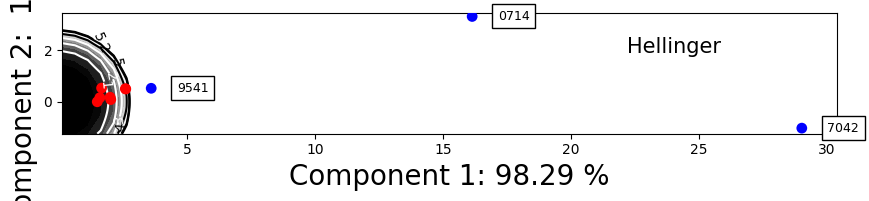

In [17]:
f = synthetic_samples_project.plot_zscore_outliers(hellinger)
f.axes[0].set_aspect("equal")

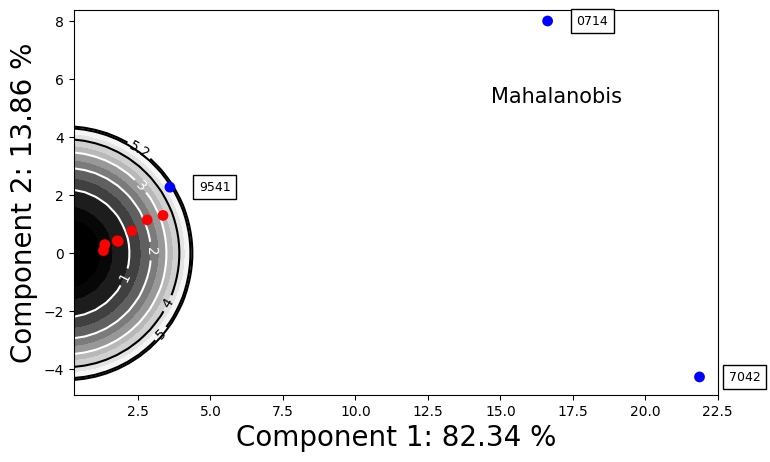

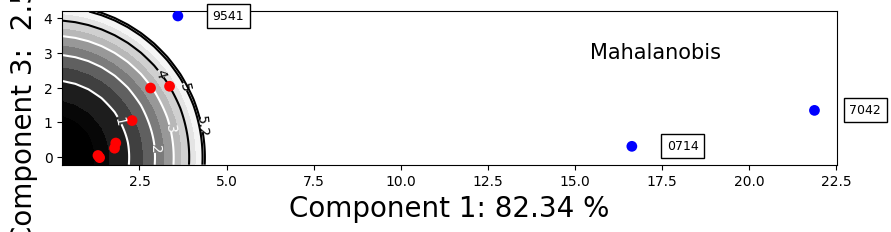

In [18]:
f = synthetic_samples_project.plot_zscore_outliers(mahalanobis)
f.axes[0].set_aspect("equal")
f = synthetic_samples_project.plot_zscore_outliers(mahalanobis, y_component=2)
f.axes[0].set_aspect("equal")

## Accessing data within a Project

### Accessing Experiment Groups

The individual {class}`.ExperimentGroup` objects can be accessed as if the {class}`.Project` were a dictionary:

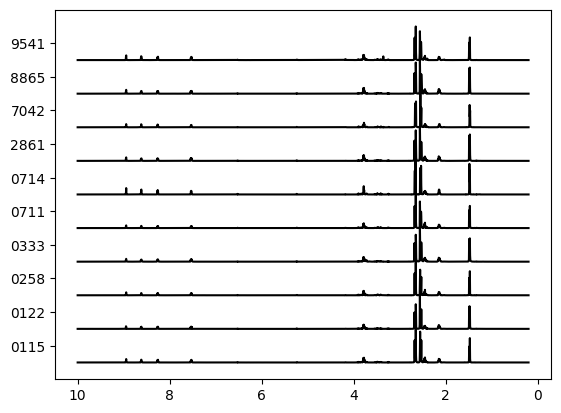

In [19]:
nmrdata = synthetic_samples_project["S6"].data.T
nmrdata = nmrdata / nmrdata.max(axis=0)
plt.plot(peakPPM_full, nmrdata + range(10), color="k")
plt.gca().set_yticks(np.array(range(10)) + 0.5)
plt.gca().set_yticklabels(Labels)
plt.gca().invert_xaxis()

You can access multiple {class}`.ExperimentGroup` objects by passing a list of names.

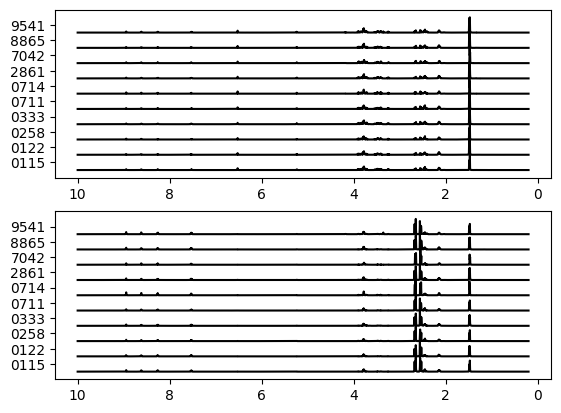

In [20]:
group_list = synthetic_samples_project[["S2", "S6"]]

fig, axes = plt.subplots(2, 1)

for group, ax in zip(group_list, axes):
    nmrdata = group.data.T
    nmrdata = nmrdata / nmrdata.max(axis=0)
    ax.plot(peakPPM_full, nmrdata + range(10), color="k")
    ax.set_yticks(np.array(range(10)) + 0.5)
    ax.set_yticklabels(Labels)
    ax.invert_xaxis()

### Accessing Distance Metrics

Individual {class}`.DistanceMetric` objects for an {class}`.ExperimentGroup` can be accessed by array-like indexing:

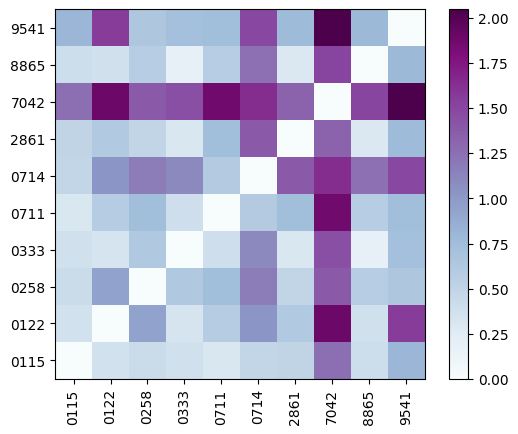

In [21]:
d = synthetic_samples_project["S6", jeffries].distance_matrix
plt.imshow(d, origin="lower", cmap="BuPu")
plt.gca().set_yticks(np.array(range(10)))
plt.gca().set_yticklabels(Labels)
plt.gca().set_xticks(np.array(range(10)))
plt.gca().set_xticklabels(Labels, rotation="vertical")
plt.colorbar()

Multiple {class}`.DistanceMetric` objects can be accessed by passing a list.

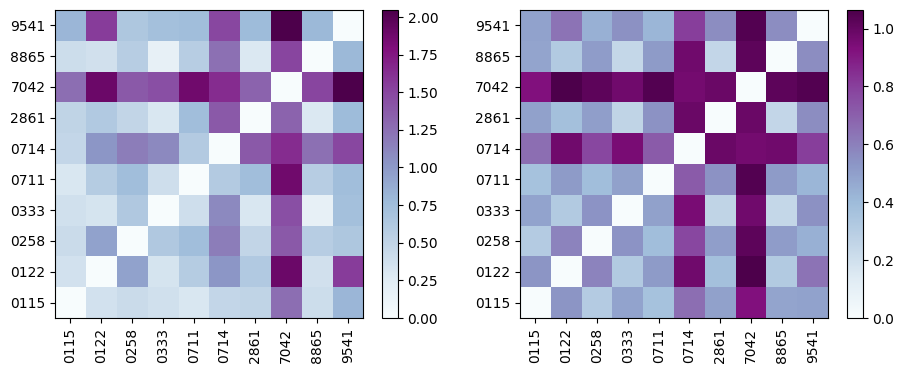

In [22]:
metric_list = synthetic_samples_project["S6", [jeffries, hellinger]]

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

for metric, ax in zip(metric_list, axes):
    d = metric.distance_matrix
    im = ax.imshow(d, origin="lower", cmap="BuPu")
    ax.set_yticks(np.array(range(10)))
    ax.set_yticklabels(Labels)
    ax.set_xticks(np.array(range(10)))
    ax.set_xticklabels(Labels, rotation="vertical")
    fig.colorbar(im, ax=ax)